# Merging RGB and Thermal Images
* Tovio Roberts

This intention of this notebook is to provide examples of merging images. The Kaist dataset used here contains parallel RGB and Thermal images. 

The four image merges shown here are:
* merge images using a scaled IR image averaged with each RGB layer
* threshold by certain level of thermal luminance
    * note that any number of thresholds may be chosen
* convert RGB to HSV, replace I with IR, revert to RGB
* convert RGB to LAB, replace L with IR, revert to RGB

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from os import listdir, getcwd
from skimage.io import imread, imsave
from skimage.color import rgb2gray, hsv2rgb, rgb2hsv, lab2rgb, rgb2lab
from skimage import img_as_ubyte
import warnings
warnings.filterwarnings('ignore')

# import utility functions
from merging_utilities.img_utils import *
from merging_utilities.os_utils import *
from merging_utilities.plotting import *
from merging_utilities.merging import *


* img utility functions: `merging_utilities/img_utils.py`
* plotting functions: `merging_utilities/plotting.py`
* merging functions: `merging_utilities/merging.py`
* os utility functions: `merging_utilities/os_utils.py`

## Read in Data

In [13]:
curr_dir = getcwd()
data_dir = curr_dir + '/images/'

data_dir = get_img_dir(data_dir)
dirs = get_img_sets()
print('data directory: ',data_dir)
print('subdirectories: ',list(dirs.keys()))

data directory:  /Users/tbot/Dropbox/galvanize/blog_posts/merge_rgb_and_thermal_images/Users/tbot/Dropbox/galvanize/blog_posts/merge_rgb_and_thermal_images/images/
subdirectories:  ['color', 'thermal']


In [14]:
image_set_filenames = get_img_sets()

color_img_filenames = image_set_filenames['color']
thermal_img_filenames = image_set_filenames['thermal']


# check_parallel_filenames(averaged_img_filenames,thermal_img_filenames)
parallel, not_parallel = verify_parallel_filenames(image_set_filenames)


YAY!, color and thermal directories are PARALLEL!


In [15]:
# check if filenames are parallel for color and thermal dirs
if color_img_filenames != thermal_img_filenames:
    print('Color and Thermal directories are NOT PARALLEL\n' + \
          '  Check the directories and try again')

### Let's read in and take a look at parallel color and thermal images from our data

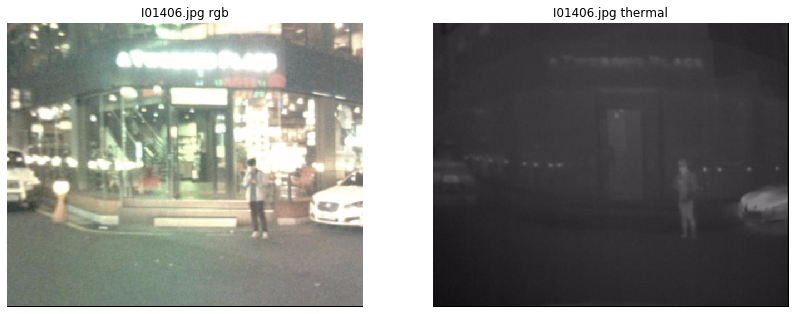

In [11]:
# get sample image
img_num = 0

img1_rgb = imread(get_img_dir() + 'color/' + \
                  color_img_filenames[img_num])
img1_ir = imread(get_img_dir() + 'thermal/' + \
                 color_img_filenames[img_num])

plot_images(img1_rgb, color_img_filenames[img_num] + ' rgb',
            img1_ir, color_img_filenames[img_num] + ' thermal')


### Let's look at the RGB image and its grayscale and channel histograms

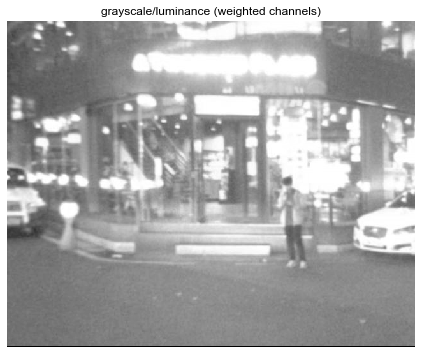

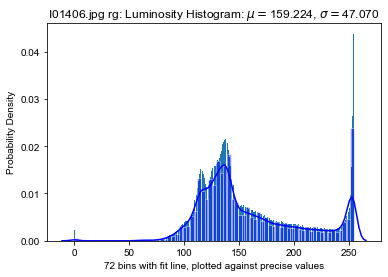

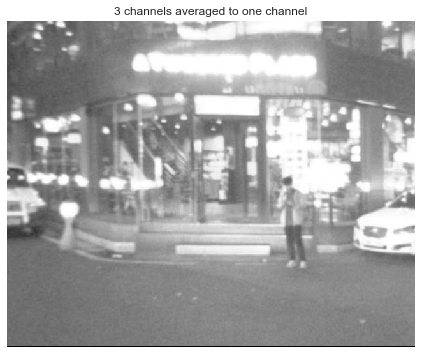

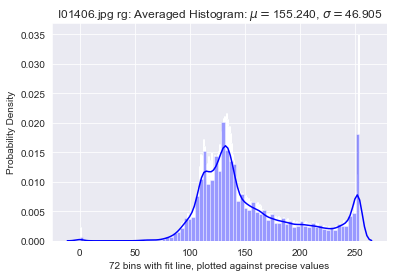

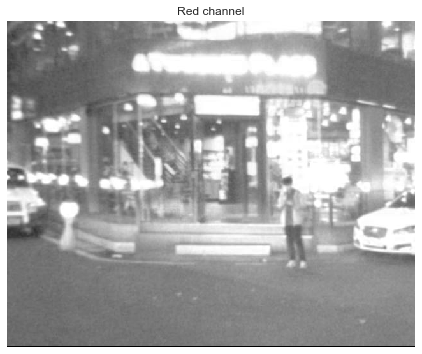

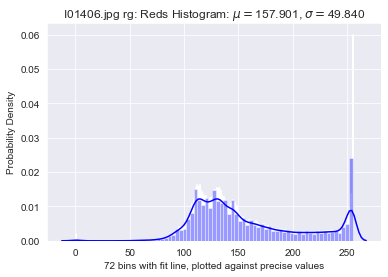

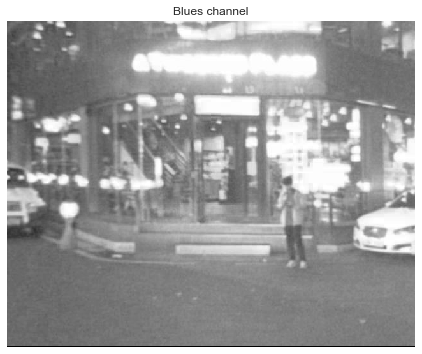

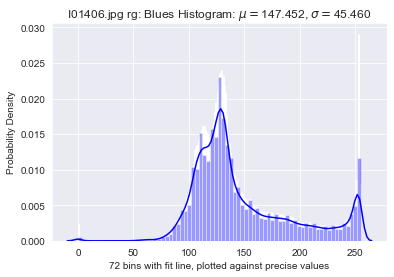

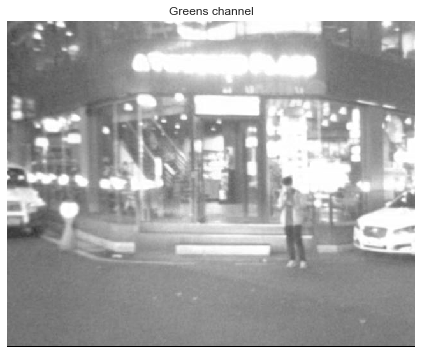

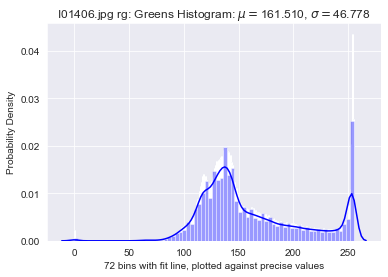

In [12]:
plot_histograms(img1_rgb, 
                color_img_filenames[img_num] + ' rgb', 
                images=True)

### Thermal image and its "grayscale" and channel histograms
* Note that we have three channels on the thermal input. They are slightly variant, but not extremely so. They will be averaged into a single thermal channel


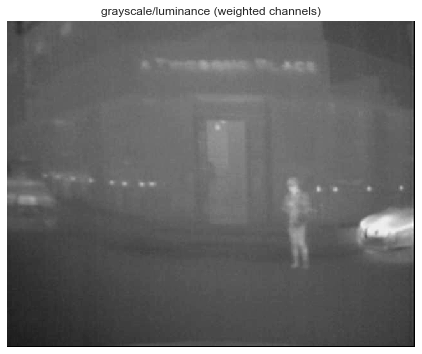

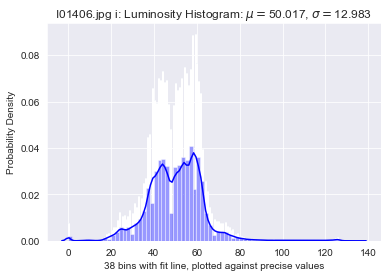

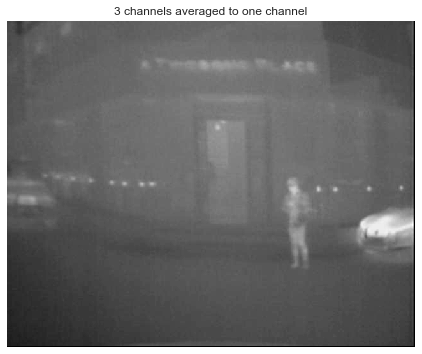

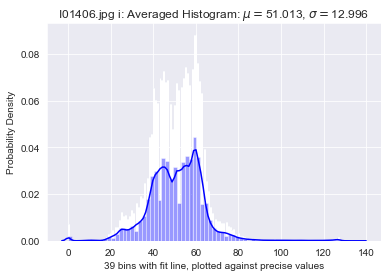

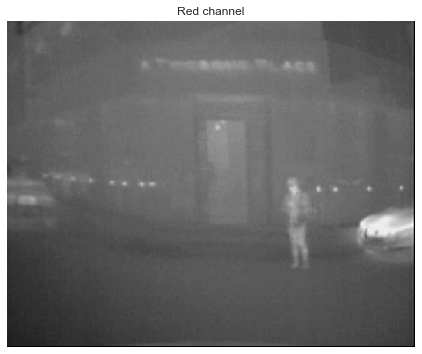

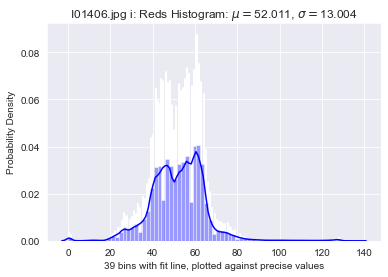

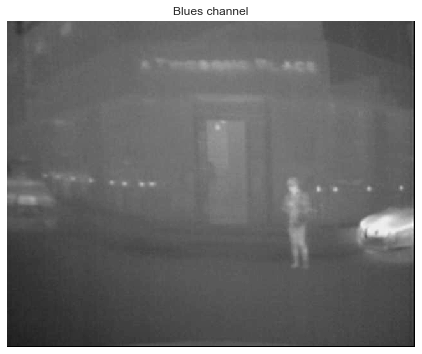

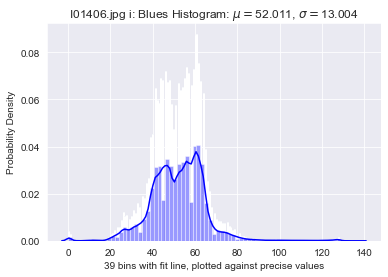

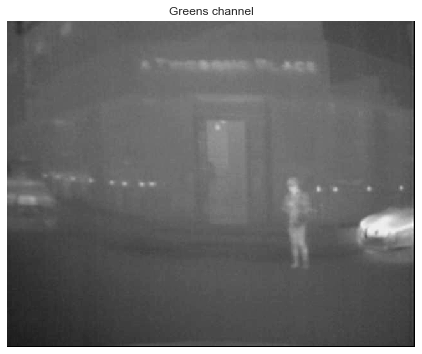

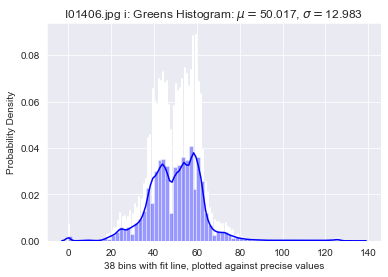

In [16]:
plot_histograms(img1_ir, 
                color_img_filenames[img_num] + ' ir',
                images=True)

### Note: we see three different layers for the Thermal image, however, we will assume they are not significantly different for our purposes. 
* The thermal layers will be compressed to a single layer for luminosity, scaled 0-255, for our purposes
* using the rgb2gray function from sklearn on the thermal layers does not evenly weight the layers, so a custom function must be used if we want evenly-weighted layer averaging
    * note that a single thermal layer has lower average values than does the rgb2gray or flattened thermal images

# Merging Images

## Average each layer with thermal layer

  91
+ 35
----
126 / 2 = 63.0 ~? 63


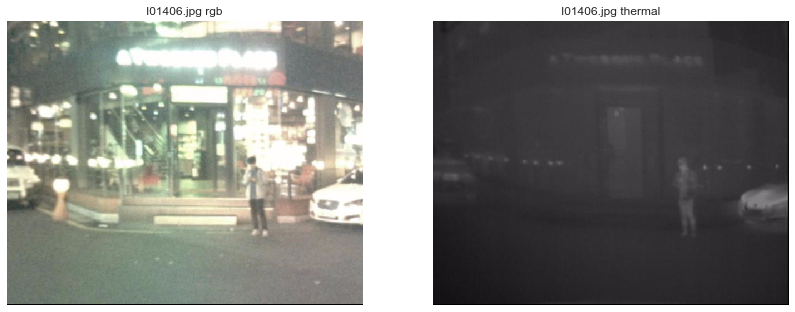

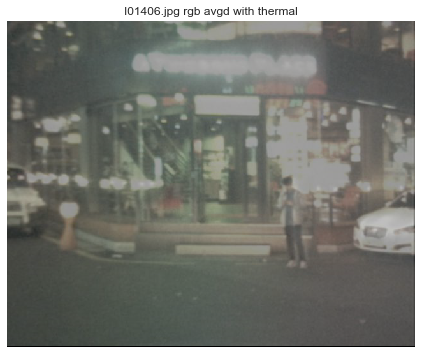

In [23]:
data_dir = get_img_dir()

samp_num = 0
img2_rgb = imread(data_dir + 'color/' + color_img_filenames[samp_num])
img2_ir = imread(data_dir + 'thermal/' + color_img_filenames[samp_num])

avgd_img2 = therm_avg(img2_rgb, img2_ir)


plot_images(img2_rgb, 
            color_img_filenames[samp_num] + ' rgb',
            img2_ir,
            color_img_filenames[samp_num] + ' thermal')
plot_image(avgd_img2, 
        color_img_filenames[samp_num] + ' rgb avgd with thermal')


# quick verify averaging of layer pix
print(' ',img2_rgb[0][0][1])
print('+',img2_ir[0][0][1])
print('----')
layr_sum = img2_rgb[0][0][1]+img2_ir[0][0][1]
print(layr_sum,'/ 2 =',layr_sum/2.,'~?',avgd_img2[0][0][1])


# Threshold by certain level of thermal luminance
* motivated by the idea that any human that is reflecting visible light will ALSO be generating thermal energy.
    * are there exceptional cases of this?


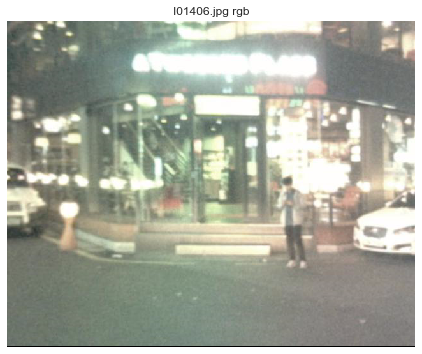

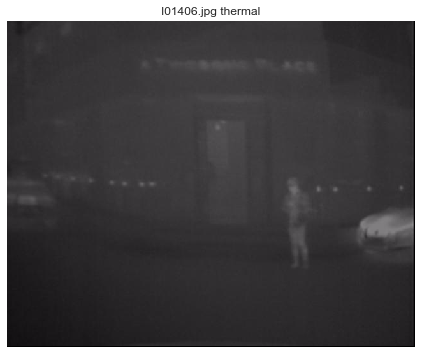

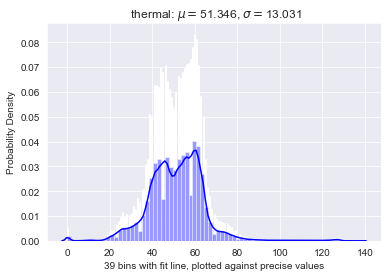

In [25]:
# let's revisit the a flattened thermal image
img3_rgb = imread(data_dir + 'color/' + color_img_filenames[samp_num])
img3_thermal = imread(data_dir + 'thermal/' + color_img_filenames[samp_num])

img4_rgb = imread(data_dir + 'color/' + color_img_filenames[samp_num])
img4_thermal = imread(data_dir + 'thermal/' + color_img_filenames[samp_num])

plot_image(img3_rgb, color_img_filenames[samp_num] + ' rgb')
plot_image(img3_thermal, color_img_filenames[samp_num] + ' thermal')
plot_histogram(img3_thermal, ' thermal')

* As a first pass, the threshold conversion will set to black all IR values less than `thresh=30`, based on values observed across histograms for this data. In the future, it may make sense to set this function parameter automatically based on analysis of the average histogram values from the entire training set. Given specific data sets (e.g., other than the Kaist data) associated with varying environmental conditions, different equipment, etc., the image values for the thermal images may require a different threshold.
    * see [Human Body Detection Technology by Thremoelectric...](https://pdfs.semanticscholar.org/c9c8/e8eb9ec8123965b2955c32735d74e560a500.pdf)

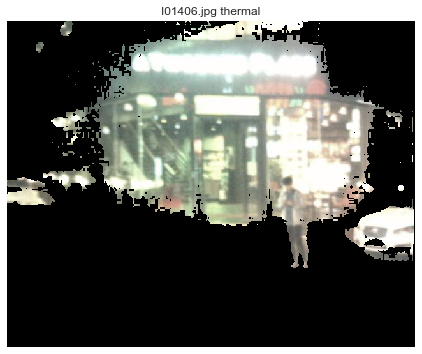

In [27]:
img3_threshed = thresh_layers_by_thermal(img3_rgb, img3_thermal, 
                                         thresh=55)
plot_image(img3_threshed, 
           color_img_filenames[samp_num] + ' thermal')

Note that this more extreme thermal threshold of `thresh=55` nearly segments people already. This characteristic motivates the strategy of creating multiple datasets using multiple thresholds, and cross validating relevant classification metrics.

Here is the same image thresholded at the default `thresh=30`

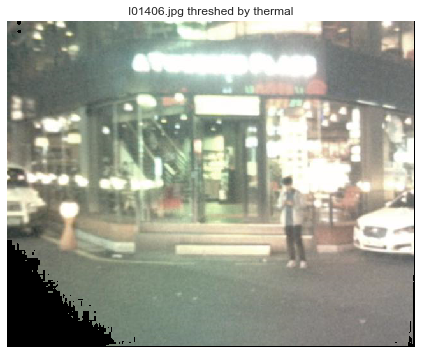

In [29]:
img4_threshed = thresh_layers_by_thermal(img4_rgb, img4_thermal, 
                                         thresh=30)
plot_image(img4_threshed, 
           color_img_filenames[samp_num] + ' threshed by thermal')

<br>

## Convert RGB to HSV, replace V with IR, revert to RGB

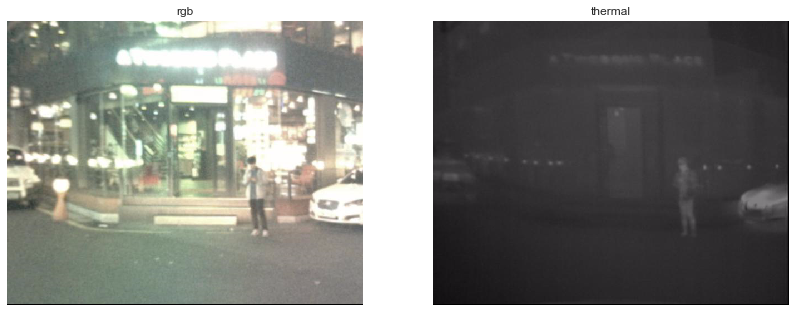

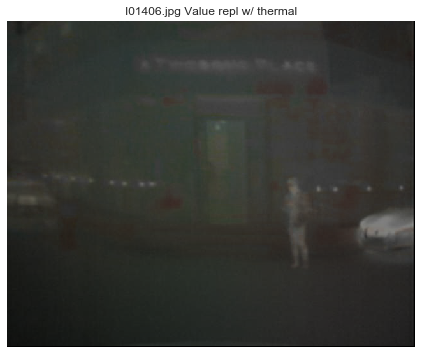

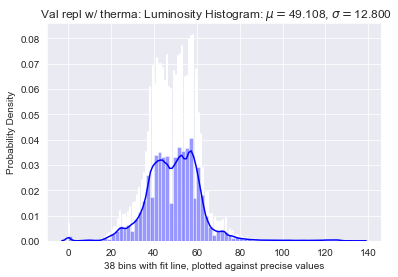

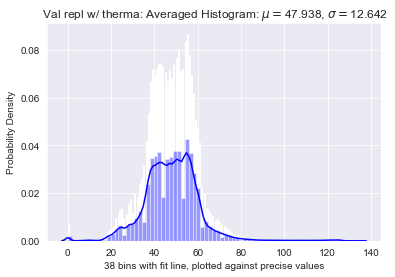

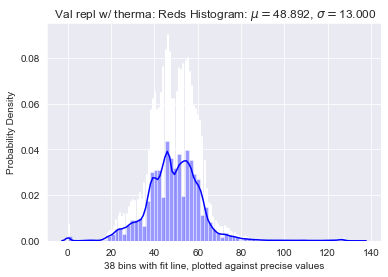

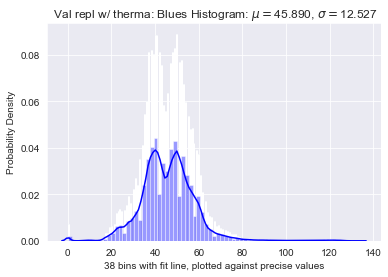

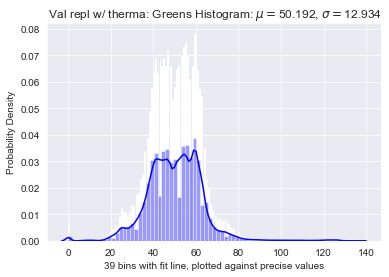

In [33]:
samp5_num = 0

img5_rgb = imread(data_dir + 'color/' \
                  + color_img_filenames[samp5_num])
img5_therm = imread(data_dir + 'thermal/' \
                 + color_img_filenames[samp5_num])

img5_val_w_therm = repl_val_with_therm(img5_rgb, img5_therm)

plot_images(img5_rgb, 'rgb',
            img5_therm, 'thermal')

plot_image(img5_val_w_therm, 
           color_img_filenames[samp5_num] + \
           ' Value repl w/ thermal')

plot_histograms(img5_val_w_therm, ' Val repl w/ thermal')

We can see that we've lost some human visual intuition here. However, people seem to still be discernible from the background. Replacing the Value (H and S mixing) channel with the thermal channel is intended to provide a latent "weight" to morphological features from heat-emitting objects (such as pedestrians).

## Convert RGB to LAB, replace L with IR, revert to RGB

As the V component in HSV describes the brighness of a color relative to the base color, the conversion back to RGB will alter darker colors, like blue, differently from how it will alter lighter colors, such as yellow.

LAB serves to address the perceptual uniformity property, to ensure the difference between two colors as perceived by the human eye. LAB color distances should be proportional to the Euclidean distance within the color space, thus preserved into the RGB space.

LAB conversion requires the application of a **standard illuminant** algorithm, which provides a theoretical source of the visible light in the image.

more info:<br>
[wikipedia: lab color space](https://en.wikipedia.org/wiki/CIELAB_color_space)<br>
[wikipedia: standard illuminant](https://en.wikipedia.org/wiki/Standard_illuminant)<br>
[re: observer angle](https://www.xrite.com/service-support/what_is_meant_by_the_term_observer_angle)

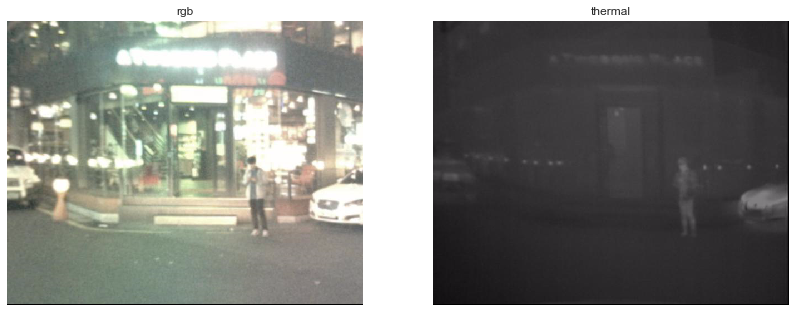

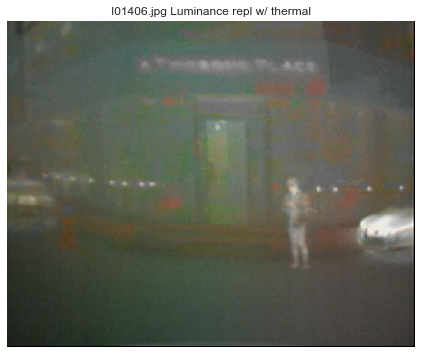

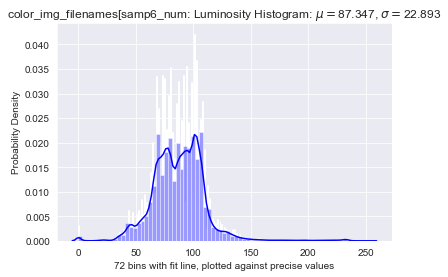

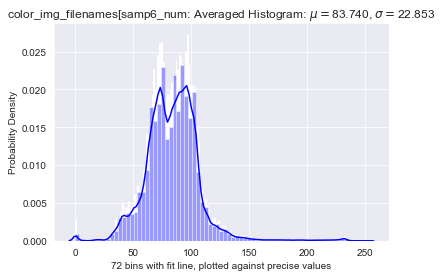

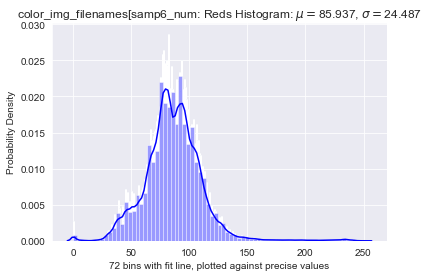

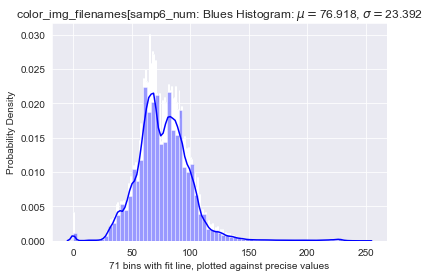

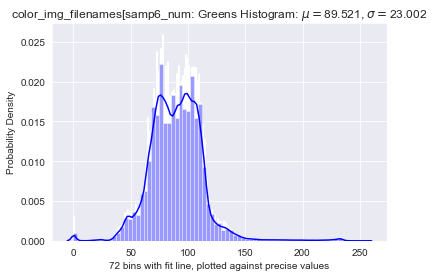

In [36]:
samp6_num = 0

img6_rgb = imread(data_dir + 'color/' \
                  + color_img_filenames[samp6_num])
img6_thermal = imread(data_dir + 'thermal/' \
                 + color_img_filenames[samp6_num])

img6_lum_w_therm = repl_light_with_therm(img6_rgb, img6_thermal)

plot_images(img6_rgb, 'rgb',
            img6_thermal, 'thermal')

plot_image(img6_lum_w_therm, 
           color_img_filenames[samp6_num] + \
           ' Luminance repl w/ thermal')

plot_histograms(img6_lum_w_therm, 
                'color_img_filenames[samp6_num]')


Note that the fusion image in this instance is rather effective at preserving color and morphological features. 